In [1]:
import fastf1 as ff1
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlp
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
ff1.Cache.enable_cache("my_cache")

In [3]:
# Downloads the qualifiers and the races of the 2018-2022 years
def download_data(years):
    for year in years:
        year_races = ff1.get_event_schedule(year)
        for event in year_races["EventName"]:
            df = ff1.get_session(year, event, "R")
            df.load()
# To do at least once if cache enabled: download_data([2018, 2019, 2020, 2021, 2022])

In [4]:
session_2020 = ff1.get_session(2020, 1, 'R')
session_2020.load()
session_2021 = ff1.get_session(2021, 1, 'R')
session_2021.load()

core           INFO 	Loading data for Austrian Grand Prix - Race [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver  8: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '16', '4', '44', '55', '11', '10', '31', '99', '5', '6', '26', '23', '7', '63', '8', '20', '18', '3', '33']
core           INFO 	Loading data for Bahrain Gran

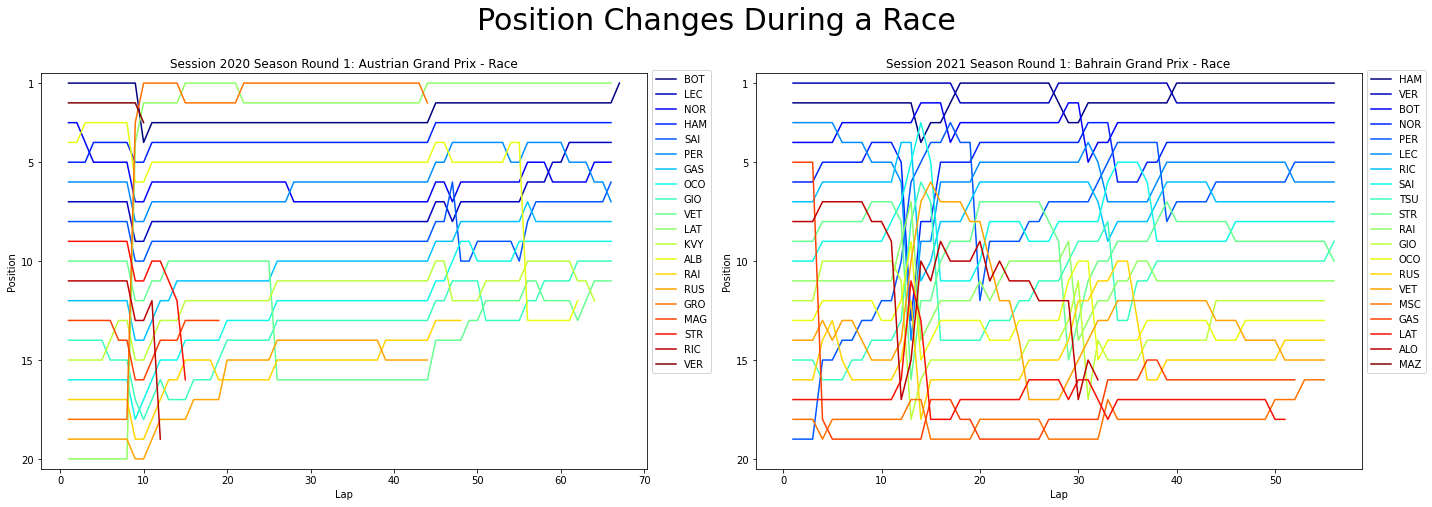

In [43]:
import fastf1.plotting
import matplotlib.pyplot as plt

# Assuming you have a list of four session objects: sessions = [session1, session2, session3, session4]
sessions = [session_2020, session_2021]

# Create a colormap with the maximum number of drivers across all sessions
max_drivers = max(len(session.drivers) for session in sessions)
cmap = plt.cm.get_cmap('jet', max_drivers)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

for session_idx, session in enumerate(sessions):
    ax = axes[session_idx]

    drivers = session.drivers

    for i, drv in enumerate(drivers):
        drv_laps = session.laps.pick_driver(drv)
        abb = drv_laps['Driver'].iloc[0]
        color = cmap(i % max_drivers)  # Get the color for the current driver
        ax.plot(list(drv_laps['LapNumber']), list(drv_laps['Position']),
                label=abb, color=color)


    ax.set_ylim([20.5, 0.5])
    ax.set_yticks([1, 5, 10, 15, 20])
    ax.set_xlabel('Lap')
    ax.set_ylabel('Position')

    ax.legend(bbox_to_anchor=(1.0, 1.02))
    ax.set_title(f'Session {session}')  # Add title with session number

# Add a title for the entire grid
fig.suptitle('Position Changes During a Race', fontsize=30, y=1)

plt.tight_layout()
plt.show()

In [13]:
years = [2018, 2019, 2020, 2021, 2022]
circuits_data = {}
for year in years:
    year_races = ff1.get_event_schedule(year)
    for event in year_races["EventName"]:
        session = ff1.get_session(year, event, "R")
        session.load()

        overtakes = []
        pits = []
        i_glob = 0
        #try:
        for i in range(len(session.laps)):
            # i_glob = i
            if i == 0:
                overtakes.append(0)
            elif session.laps["Position"][i] != session.laps["Position"][i-1]:
                overtakes.append(1)
            else:
                overtakes.append(0)

            if session.laps["LapNumber"][i] == 1:
                pits.append(0)
            elif session.laps["PitInTime"][i] is None or str(session.laps["PitInTime"][i]) == "NaT":
                pits.append(0)
            else:
                pits.append(1)
        session.laps["Overtake"] = overtakes
        session.laps["PitStop"] = pits
        if event not in circuits_data.keys():
            circuits_data[event] = [session.laps]
        else:
            circuits_data[event].append(session.laps)
        # except KeyError:
        #     print(i_glob)
        #     break


final_data = {}
for circuit in circuits_data:
    final_data[circuit] = pd.concat(circuits_data[circuit])

for key, value in final_data.items():
    print(key, value.shape)

core           INFO 	Loading data for Australian Grand Prix - Race [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	No cached data found for position_data. Loading data...
_api           INFO 	Fetching position data...
logger      WARNING 	Failed to load telemetry data!
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['5', '44', '7', '3', '14', '33', '27', '77', '2', '55', '11', '31', '16', '18', '28', '8', '20', '10', '9', '35']
core    

Australian Grand Prix (3026, 33)
Bahrain Grand Prix (5256, 33)
Chinese Grand Prix (2161, 33)
Azerbaijan Grand Prix (3630, 33)
Spanish Grand Prix (6048, 33)
Monaco Grand Prix (5605, 33)
Canadian Grand Prix (3796, 33)
French Grand Prix (3966, 33)
Austrian Grand Prix (6359, 33)
British Grand Prix (4498, 33)
German Grand Prix (2312, 33)
Hungarian Grand Prix (6286, 33)
Belgian Grand Prix (3101, 33)
Italian Grand Prix (4707, 33)
Singapore Grand Prix (3256, 33)
Russian Grand Prix (3822, 33)
Japanese Grand Prix (2489, 33)
United States Grand Prix (4000, 33)
Mexican Grand Prix (2615, 33)
Brazilian Grand Prix (2703, 33)
Abu Dhabi Grand Prix (5179, 33)
Pre-Season Test 1 (1288, 33)
Pre-Season Test 2 (1288, 33)
Styrian Grand Prix (2523, 33)
70th Anniversary Grand Prix (1025, 33)
Tuscan Grand Prix (786, 33)
Eifel Grand Prix (1019, 33)
Portuguese Grand Prix (2533, 33)
Emilia Romagna Grand Prix (3390, 33)
Turkish Grand Prix (2224, 33)
Sakhir Grand Prix (1534, 33)
Pre-Season Test (2009, 33)
Dutch Grand

In [16]:
def circuits_to_csv(circuits_list):
    if not os.path.isdir("data"):
        os.makedirs("data", exist_ok=True)
    for circuit in circuits_list:
        circuits_list[circuit].to_csv(f"data/{circuit.replace(' ', '_')}.csv", index=False)

circuits_to_csv(final_data)

In [22]:
def get_model(circuit_name, circuit_df):
    circuit_df.dropna(axis=1, how="all", inplace=True)
    circuit_df.fillna(-99999, inplace=True)

    features_list = circuit_df.drop(columns=["Overtake", "DriverNumber"])
    features_list = features_list.select_dtypes(include=["float64", "int64"])
    df_target = circuit_df["Overtake"]

    corr_df = features_list.corr(method="spearman")

    distance_matrix = 1 - corr_df.abs()

    def select_features(my_clustering, features_list):
        selected_features = [] # it will be a list with names of the selected features. If you have 10 clusters, it will be a list with ten features
        index_features = np.arange(len(features_list))  # array from 0 to (number of features-1)
        for ind_l in set(my_clustering.labels_): # cycle from 0 to number of clusters
            mask = my_clustering.labels_ == ind_l # create mask to consider cluster ind_l
            feat_list = [features_list[i] for i in list(index_features[mask])] # select all features belonging to cluster ind_l
            selected_features.append(feat_list[0]) # select only the first feature of the cluster
            if False:
                print(f"Cluster {ind_l}")
                print(f"Selected feature: {feat_list[0]}")
        return selected_features

    x_train, x_val, y_train, y_val = train_test_split(features_list, df_target, test_size=0.25, random_state=24)

    def train_model(x_train, y_train, x_val, y_val, features):
        model = RandomForestClassifier(random_state=24)
        model.fit(x_train[features], y_train)
        accuracy_val = model.score(x_val[features], y_val)
        return accuracy_val, model

    def feature_selector(x_train, y_train, x_val, y_val, distance_matrix, features_list, n_f):
        my_clustering = AgglomerativeClustering(n_clusters=n_f, linkage = 'single', affinity='precomputed')
        my_clustering = my_clustering.fit(distance_matrix)

        selected_features = select_features(my_clustering, features_list)
        accuracy_val, model = train_model(x_train, y_train, x_val, y_val, selected_features)

        return selected_features, accuracy_val, model

    accuracies = []
    num_features = []
    best_features = []
    best_model = None
    best_n_f, best_acc = 0, 0
    for n_f in range(1, len(features_list.columns)+1): # varying number of features
        num_features.append(n_f)
        selected_features, accuracy_val, model = feature_selector(x_train, y_train, x_val, y_val,  distance_matrix, features_list.columns, n_f)
        accuracies.append(accuracy_val)
        if best_acc < accuracy_val:
            best_n_f, best_acc, best_features, best_model = n_f, accuracy_val, selected_features, model
        if n_f == len(features_list.columns):
            proba = best_model.predict_proba(x_val[best_features])
            y_score = proba[:, 1]

            fpr, tpr, _ = roc_curve(y_val, y_score)
            roc_auc = auc(fpr, tpr)

            plt.figure(figsize=(4, 4))
            plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC for {circuit_name}')
            plt.legend(loc="lower right")
            plt.show()

    #print(f'Best accuracy of {best_acc} reached with {best_n_f} features')
    return model, best_acc, best_features

In [23]:
def get_circuits_models():
    directory = 'data'

    if not os.path.isdir(directory):
        os.makedirs(directory, exist_ok=True)

    dataframes = {}
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            df = pd.read_csv(os.path.join(directory, filename))
            base_filename = os.path.splitext(filename)[0]
            dataframes[base_filename] = df

    circuits_models = {}
    for circuit in dataframes:
        # key is the name of the circuit, value is a list with model, its accuracy and the features used for it
        circuits_models[circuit] = get_model(circuit, dataframes[circuit])
    return circuits_models

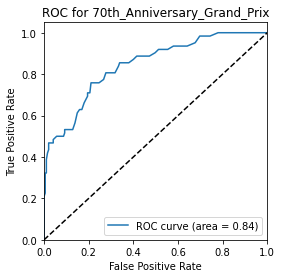

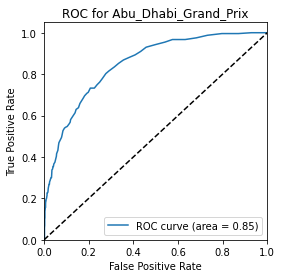

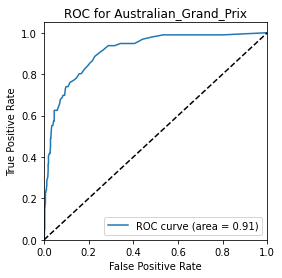

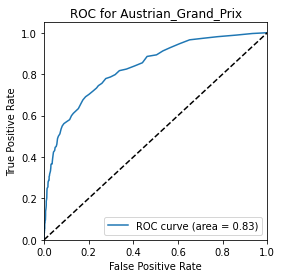

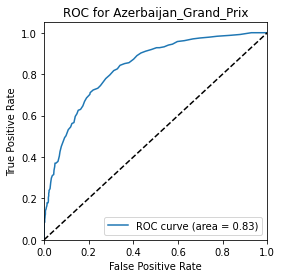

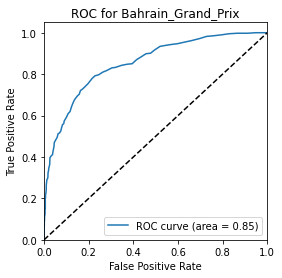

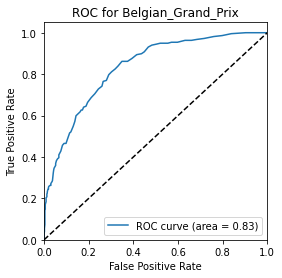

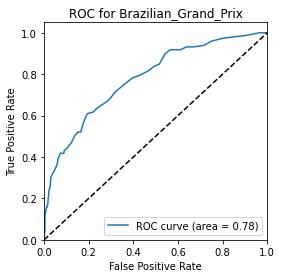

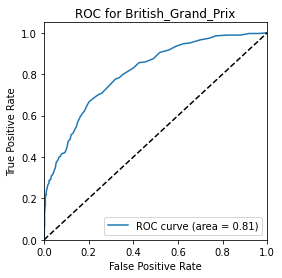

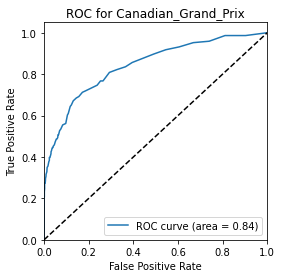

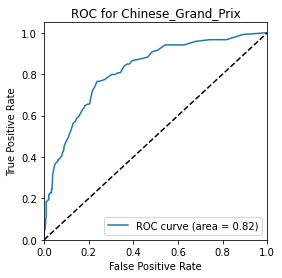

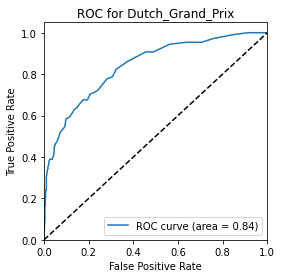

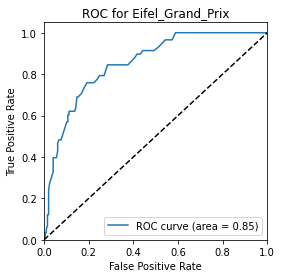

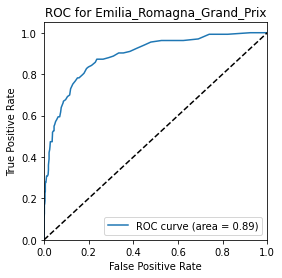

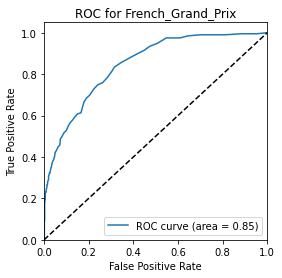

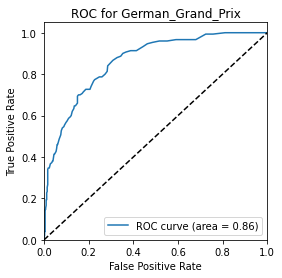

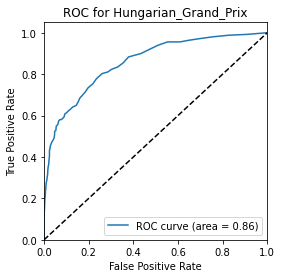

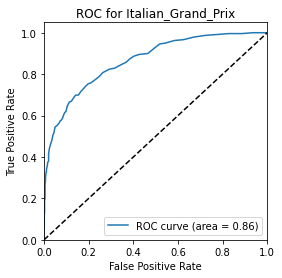

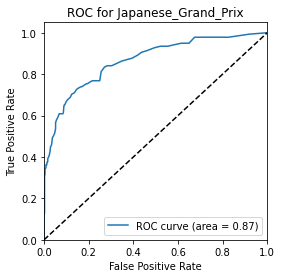

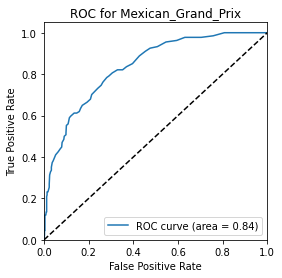

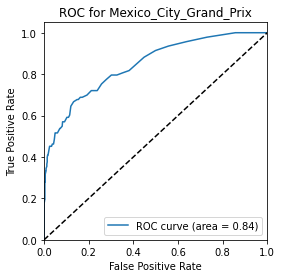

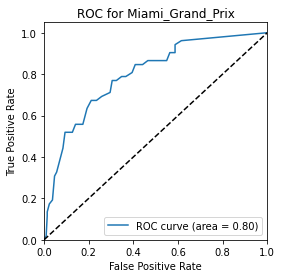

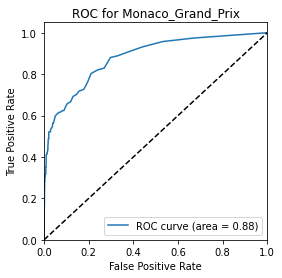

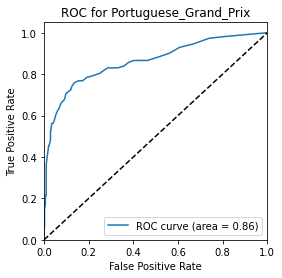

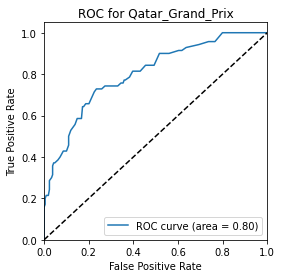

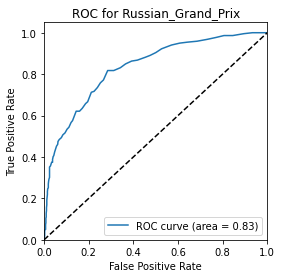

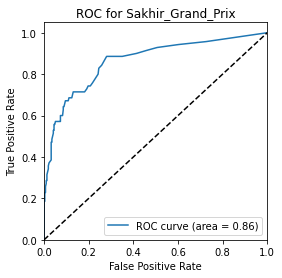

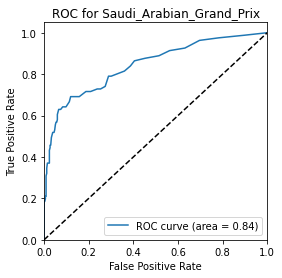

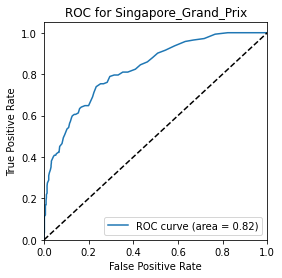

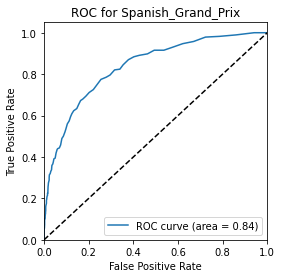

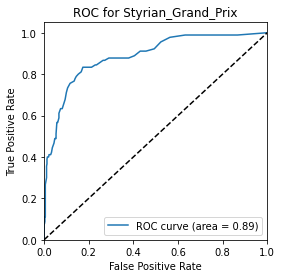

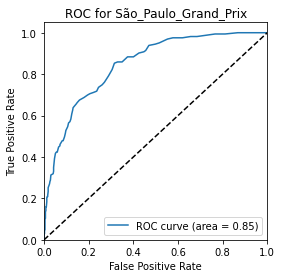

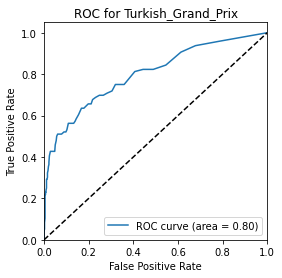

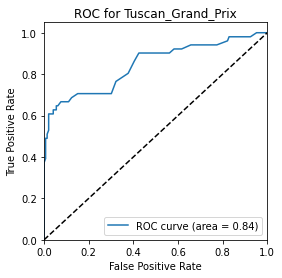

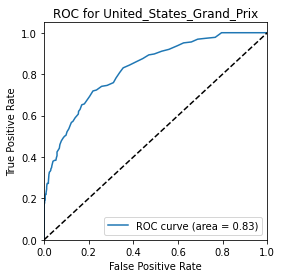

70th_Anniversary_Grand_Prix, 0.8443579766536965 accuracy. Features used for this model:
	['LapNumber', 'PitStop', 'Position', 'TrackStatus', 'TyreLife', 'SpeedFL', 'SpeedST', 'SpeedI1', 'SpeedI2']
Abu_Dhabi_Grand_Prix, 0.8455598455598455 accuracy. Features used for this model:
	['PitStop', 'TrackStatus', 'Position', 'TyreLife', 'Stint', 'SpeedI1', 'SpeedFL', 'SpeedI2', 'SpeedST', 'LapNumber']
Australian_Grand_Prix, 0.9035667107001321 accuracy. Features used for this model:
	['SpeedI2', 'LapNumber', 'PitStop', 'SpeedI1', 'Position', 'TrackStatus', 'SpeedST']
Austrian_Grand_Prix, 0.8666666666666667 accuracy. Features used for this model:
	['LapNumber', 'Position', 'PitStop', 'TrackStatus', 'SpeedST', 'SpeedFL', 'SpeedI2', 'SpeedI1', 'TyreLife']
Azerbaijan_Grand_Prix, 0.7995594713656388 accuracy. Features used for this model:
	['SpeedI1', 'LapNumber', 'Position', 'PitStop', 'SpeedFL', 'TrackStatus', 'TyreLife']
Bahrain_Grand_Prix, 0.8074581430745814 accuracy. Features used for this model:

In [24]:
models_results = get_circuits_models()
for circuit in models_results:
    model, acc, features = models_results[circuit]
    print(f"{circuit}, {acc} accuracy. Features used for this model:\n\t{features}")

In [25]:
# To get the common features
feature_lists = [value[2] for value in models_results.values()]
common_features = list(set.intersection(*map(set, feature_lists)))
print("Common features:\n\t", ', '.join(common_features))

Common features:
	 LapNumber


LapNumber: 35
PitStop: 34
Position: 33
SpeedI1: 33
TyreLife: 32
TrackStatus: 29
SpeedI2: 28
SpeedST: 26
SpeedFL: 25
Stint: 14


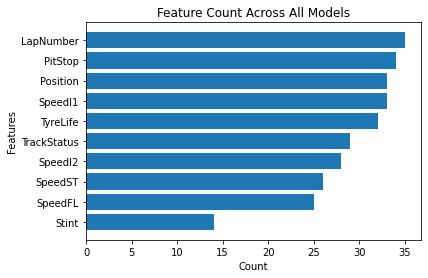

In [26]:
all_features = [feature for sublist in feature_lists for feature in sublist]
feature_counter = Counter(all_features)

# Plot feature count
features, counts = zip(*feature_counter.most_common())
for i, feature in enumerate(features):
    print(f"{features[i]}: {counts[i]}")
plt.barh(features, counts)
plt.xlabel('Count')
plt.ylabel('Features')
plt.title('Feature Count Across All Models')
plt.gca().invert_yaxis()  # To display highest count at the top
plt.show()